In [4]:
from typing import Annotated  #hypotetical metadat type 
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages #it reducer-> adds/appends messages to the list instead of replacing them


In [5]:
class State(TypedDict):         #typeddi used for taking value in dictory format
     messages:Annotated[list,add_messages]


In [6]:
import os 
from dotenv import load_dotenv
load_dotenv()

True

In [7]:
from langchain.chat_models import init_chat_model
from langchain_groq import ChatGroq
llm = ChatGroq(model="openai/gpt-oss-20b")


In [8]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002308231E3C0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000023083C76B40>, model_name='openai/gpt-oss-20b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [9]:
#Node funcitonaluty 
def chatbot(state:State):
  return {"messages":[llm.invoke(state["messages"])]}  #the msg variblae is same as we declar in the class State 

In [10]:
graph_builder = StateGraph(State)
graph_builder.add_node("llmchatbot",chatbot)

graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)

#compiling thr graph 
graph = graph_builder.compile()

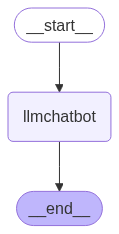

In [11]:
#vsiulaization graph 
from IPython.display import Image,display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass  

In [12]:
response = graph.invoke({"messages":"hi"})

In [13]:
response["messages"][-1].content  #reading the data

'Hello! 👋 How can I help you today?'

In [14]:
for event in graph.stream({"messages":"Hi How are you?"}): #Streaming 
  for value in event.values():
    print(value["messages"][-1].content)

Hey! I’m doing great—thanks for asking. How about you? What’s new on your end?


### How to make use of the tools in Agent


In [15]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_result=2)
tool.invoke("What is langgraph ?")

{'query': 'What is langgraph ?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.geeksforgeeks.org/machine-learning/what-is-langgraph/',
   'title': 'What is LangGraph? - GeeksforGeeks',
   'content': 'LangGraph is an open-source framework built by LangChain that streamlines the creation and management of AI agent workflows.',
   'score': 0.9470345,
   'raw_content': None},
  {'url': 'https://huggingface.co/learn/agents-course/en/unit2/langgraph/when_to_use_langgraph',
   'title': 'What is LangGraph ? - Hugging Face Agents Course',
   'content': 'What is LangGraph ? # What is LangGraph ? `LangGraph` is a framework developed by LangChain **to manage the control flow of applications that integrate an LLM**. `LangGraph` is on the other end of the spectrum, it shines when you need **“Control”** on the execution of your agent. LangGraph is particularly valuable when you need **Control over your applications**. Put simply, if your application i

In [16]:
# defining the DOC STRING
def multiply(a:int,b:int)->int:
  """Multiply a and b 

  Args:
  a (int): first int
  b (int): second int 

  Returns:
  int:output int

"""
  return a*b


In [17]:
tools = [tool,multiply]  #we are using 2 tools

In [18]:
llm_with_tool=llm.bind_tools(tools)

In [19]:
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002308231E3C0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000023083C76B40>, model_name='openai/gpt-oss-20b', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A l

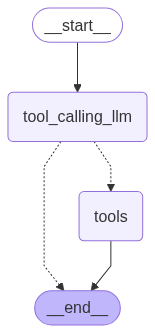

In [20]:
## State Graph 
#creating a toolnode 
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

##node def
def tool_calling_llm(state:State):
  return {"messages":[llm_with_tool.invoke(state["messages"])]}


##graph 
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

#add edges 
builder.add_edge(START,"tool_calling_llm")
# builder.add_edge("tool_calling_llm",tools_condition)
builder.add_conditional_edges(
    "tool_calling_llm",  # from this node
    tools_condition,     # condition function
)
builder.add_edge("tools", END)

#complining the graph 
graph = builder.compile()

from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))


In [21]:
response = graph.invoke({"messages":"What is the recent ai news"})

In [22]:
response['messages'][-1].content

'{"query": "latest AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://med.stanford.edu/news/all-news/2025/09/ai-crispr-gene-therapy.html", "title": "AI-powered CRISPR could lead to faster gene therapies, Stanford ...", "content": "Artificial Intelligence (AI)   June 05, 2025\\n\\nChatEHR, artificial intelligence software developed at Stanford Medicine, is expediting chart reviews and other tasks by allowing clinicians to ask questions of medical records.\\n\\ntolias-brain-model\\n\\nArtificial Intelligence (AI)   April 09, 2025\\n\\nIn a new study, researchers created an AI model of the mouse visual cortex that predicts neuronal responses to visual images.\\n\\nNigam-Shah-LLM-1\\n\\nArtificial Intelligence (AI)   April 08, 2025 [...] As artificial intelligence pervades health and medicine, researchers have developed a new evaluation framework to help scientists determine which type of algorithms are best suited for health care.\\n\\nai-aid

In [23]:
for m in response['messages']:
  m.pretty_print()

================================ Human Message =================================

What is the recent ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fc_e96662f2-76de-4573-aa05-3016496aad29)
 Call ID: fc_e96662f2-76de-4573-aa05-3016496aad29
  Args:
    include_favicon: False
    include_images: False
    query: latest AI news
    search_depth: advanced
    time_range: day
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "latest AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://med.stanford.edu/news/all-news/2025/09/ai-crispr-gene-therapy.html", "title": "AI-powered CRISPR could lead to faster gene therapies, Stanford ...", "content": "Artificial Intelligence (AI)   June 05, 2025\n\nChatEHR, artificial intelligence software developed at Stanford Medicine, is expediting chart reviews and othe

In [24]:
#fro mulitply invoke
response = graph.invoke({"messages":"what is 2 multiplied by 4"})
for m in response['messages']:
  m.pretty_print()

================================ Human Message =================================

what is 2 multiplied by 4
================================== Ai Message ==================================

2 multiplied by 4 equals **8**.


### ReAct Agent Architecture 


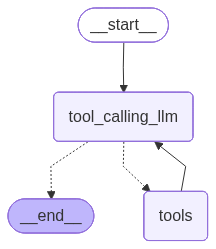

In [25]:
## State Graph 
#creating a toolnode 
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

##node def
def tool_calling_llm(state:State):
  return {"messages":[llm_with_tool.invoke(state["messages"])]}


##graph 
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

#add edges 
builder.add_edge(START,"tool_calling_llm")
# builder.add_edge("tool_calling_llm",tools_condition)
builder.add_conditional_edges(
    "tool_calling_llm",  # from this node
    tools_condition,     # condition function
)
builder.add_edge("tools","tool_calling_llm")

#complining the graph 
graph = builder.compile()

from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
response = graph.invoke({"messages":"what is 2 multiplied by 4 and then give me latest news"})
for m in response['messages']:
  m.pretty_print()

================================ Human Message =================================

what is 2 multiplied by 4 and then give me latest news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fc_a7bf7ce2-77e5-4610-841f-39df4626e395)
 Call ID: fc_a7bf7ce2-77e5-4610-841f-39df4626e395
  Args:
    query: latest news
    search_depth: advanced
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "latest news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.babushahi.com/full-news.php?id=210703", "title": "MP Satnam Sandhu highlights Punjab’s role in self-reliant India at ARCHSPIRE 2025 - Babushahi News", "score": 0.5393963, "published_date": "Sun, 14 Sep 2025 13:12:00 GMT", "content": "Sep 14, 2025Top News Stories of September 14 till 8:30 pm (One-Minute Read)  Sep 14, 2025Delhi Sikh Gurudwara Committee condemns racial

### ADDING MEMORY in GRAPH


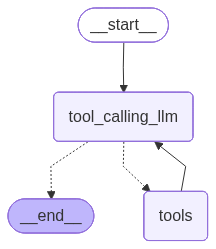

In [29]:
## State Graph 
#creating a toolnode 
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver  #to remember previous context 

memory = MemorySaver()

##node def
def tool_calling_llm(state:State):
  return {"messages":[llm_with_tool.invoke(state["messages"])]}


##graph 
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

#add edges 
builder.add_edge(START,"tool_calling_llm")
# builder.add_edge("tool_calling_llm",tools_condition)
builder.add_conditional_edges(
    "tool_calling_llm",  # from this node
    tools_condition,     # condition function
)
builder.add_edge("tools","tool_calling_llm")

#complining the graph 
graph = builder.compile(checkpointer=memory)

from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))

In [30]:
config = {"configurable":{"thread_id":"1"}}

response = graph.invoke({"messages":"Hi my name is Chirag"},config=config)

response

{'messages': [HumanMessage(content='Hi my name is Chirag', additional_kwargs={}, response_metadata={}, id='08685a90-d341-4321-9406-99b537ba5db0'),
  AIMessage(content='Hello Chirag! 👋 How can I help you today?', additional_kwargs={'reasoning_content': 'The user just said "Hi my name is Chirag". Probably greeting. We should respond warmly. No search needed.'}, response_metadata={'token_usage': {'completion_tokens': 47, 'prompt_tokens': 1391, 'total_tokens': 1438, 'completion_time': 0.043615438, 'prompt_time': 0.090656184, 'queue_time': 0.050647585, 'total_time': 0.134271622}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_a5ac2a5d7b', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--1a3f45e1-3cb4-457f-ad58-7ffb9ea2f865-0', usage_metadata={'input_tokens': 1391, 'output_tokens': 47, 'total_tokens': 1438})]}

In [31]:
response = graph.invoke({"messages":"What is my name"},config=config)
print(response['messages'][-1].content)


You’re Chirag.
